In [11]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%reload_ext autoreload
%autoreload 2

import torch
from data_provider.data_factory import data_provider
from types import SimpleNamespace
from models import Crossformer, PatchTST, iTransformer
from sklearn.metrics import mean_squared_error

In [2]:
DATA_PATH = "./dataset/USC"
MODEL_PATH = Path('./pruning/top_exps')
BEST_EXPS = {16: '7_055', 
            #  32: '1_050', 
             32: '1_153',
             64: '27_034', 
             128: '21_113'}

In [3]:
th = 32

dp_args = SimpleNamespace(**{"root_path" : DATA_PATH, 
                                       'data_path' : 'na',
                                       "data":'USC', 
                                       'seq_len':th, 
                                       'pred_len':th, 
                                       'label_len':0,
                                       'scale':True,
                                       # Default args to allow loader to work
                                       'model':'Transformer',
                                       'task_name':'long_term_forecast',
                                       'embed':'timeF',
                                       'features':'MS',
                                       'use_action_progress':True,
                                       'use_offense':False,
                                       'consider_only_offense':True,
                                       'batch_size':256,
                                       'freq':'h',
                                       'seasonal_patterns':'Monthly',
                                       'num_workers' : 1,
                                       'target':'na'})
uscds, uscdl = data_provider(args=dp_args, flag = 'test')

In [4]:
exp_path = MODEL_PATH / BEST_EXPS[th] / 'best.pt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(exp_path, map_location=torch.device(device))
### Dynamically import and instantiate the model class
module_name = checkpoint['model_module']
class_name = checkpoint['model_class']
model_args = checkpoint['model_args']
### Import the module and get the class
module = __import__(module_name, fromlist=[class_name])
model_class = getattr(module, class_name)
### Create model instance using saved arguments
model = model_class(model_args)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [5]:
def evaluate_model(model, data_loader, metric_fn):
    """Evaluate model on data_loader"""
    model.eval()
    device = next(model.parameters()).device
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for inputs, targets, _, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs, None, None, None)
            all_preds.append(outputs.cpu())
            all_targets.append(targets)
    
    preds = torch.cat(all_preds)
    targets = torch.cat(all_targets)
    
    return metric_fn(targets, preds)


def evaluate_with_permuted_feature(model, data_loader, metric_fn, 
                                   feature_idx, timesteps):
    """Evaluate with one feature permuted"""
    model.eval()
    device = next(model.parameters()).device
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for inputs, targets, _, _ in data_loader:
            # Permute the feature across the batch
            permuted_inputs = inputs.clone()
            perm_idx = torch.randperm(inputs.size(0))
            permuted_inputs[:, :, feature_idx] = inputs[perm_idx, :, feature_idx]
            
            permuted_inputs = permuted_inputs.to(device)
            outputs = model(permuted_inputs, None, None ,None)
            all_preds.append(outputs.cpu())
            all_targets.append(targets)
    
    preds = torch.cat(all_preds)
    targets = torch.cat(all_targets)
    
    return metric_fn(targets, preds)


In [ ]:
def permutation_importance(model, data_loader, metric_fn, n_repeats=10):
    """
    Compute permutation importance for each feature
    Args:
        model: PyTorch model
        data_loader: DataLoader with validation data
        metric_fn: function(y_true, y_pred) -> score
        n_repeats: number of permutation repeats
    Returns:
        importance: shape (features,)
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get baseline score
    baseline_score = evaluate_model(model, data_loader, metric_fn)
    
    # Get data shape
    sample_batch = next(iter(data_loader))
    _, timesteps, n_features = sample_batch[0].shape
    
    importance_scores = np.zeros(n_features)
    
    for feature_idx in range(n_features):
        scores = []
        print(f"Processing feature n° {feature_idx+1:>3} out of {n_features:>3} ...", end = '\r')
        for _ in range(n_repeats):
            # Permute feature across all samples
            permuted_score = evaluate_with_permuted_feature(
                model, data_loader, metric_fn, feature_idx, timesteps
            )
            scores.append(baseline_score - permuted_score)
        mean_score = np.mean(scores)
        importance_scores[feature_idx] = mean_score
        print(f"Processing feature n° {feature_idx:>3} out of {n_features:>3} | importance score: {mean_score:.2e} ")
        
    
    return importance_scores

In [7]:
def final_displacement_error(true, preds):
    return mean_squared_error(true[:,-1], preds[:,-1])

In [12]:
perm_imp = permutation_importance(model, uscdl, final_displacement_error, n_repeats=4)

Processing feature n°   0 out of  61 | importance score: -3.67e-03 
Processing feature n°   1 out of  61 | importance score: -1.61e-03 
Processing feature n°   2 out of  61 | importance score: -3.80e-03 
Processing feature n°   3 out of  61 | importance score: -1.29e-03 
Processing feature n°   4 out of  61 | importance score: -3.92e-03 
Processing feature n°   5 out of  61 | importance score: -2.31e-03 
Processing feature n°   6 out of  61 | importance score: -6.23e-03 
Processing feature n°   7 out of  61 | importance score: -3.96e-04 
Processing feature n°   8 out of  61 | importance score: -4.29e-03 
Processing feature n°   9 out of  61 | importance score: -2.06e-03 
Processing feature n°  10 out of  61 | importance score: -4.83e-03 
Processing feature n°  11 out of  61 | importance score: -9.56e-04 
Processing feature n°  12 out of  61 | importance score: -3.76e-03 
Processing feature n°  13 out of  61 | importance score: -2.50e-03 
Processing feature n°  14 out of  61 | importanc

In [20]:
pi_df = pd.DataFrame(data = -perm_imp[:60], index = range(60), columns = ['permutation_importance'])
pi_df['player'] = [(x // 4) +1 for x in pi_df.index]
pi_df['kpi'] = [x % 4 for x in pi_df.index]
kpi_map = {0: 'x', 1: 'y', 2: 'v', 3:'angle'}
pi_df['kpi'] = pi_df['kpi'].map(kpi_map)
pi_df

,permutation_importance,player,kpi
0,0.003672,1,x
1,0.001608,1,y
2,0.003795,1,v
3,0.001286,1,angle
4,0.003924,2,x
5,0.002308,2,y
6,0.006234,2,v
7,0.000396,2,angle
8,0.004285,3,x
9,0.002063,3,y


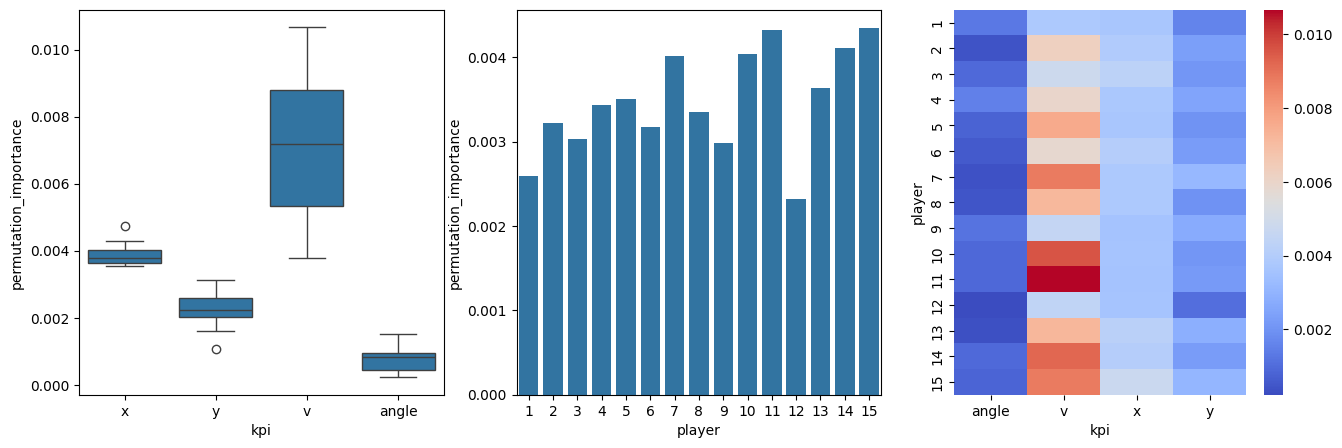

In [22]:
fig, axs = plt.subplots(1,3,figsize = (16,5))
sns.boxplot(data = pi_df, x = 'kpi', y = 'permutation_importance', ax = axs[0]);
sns.barplot(data = pi_df, x = 'player', y = 'permutation_importance', ax = axs[1], errorbar=None);
sns.heatmap(data= pi_df.pivot(index = 'player', columns = ['kpi'], values = 'permutation_importance'), cmap = 'coolwarm', ax = axs[2]);  


In [25]:
pi_df.sort_values('permutation_importance', ascending = False)

,permutation_importance,player,kpi
42,0.010666,11,v
38,0.009584,10,v
54,0.009211,14,v
58,0.008783,15,v
26,0.008774,7,v
18,0.007573,5,v
50,0.007214,13,v
30,0.007186,8,v
6,0.006234,2,v
14,0.005956,4,v
